# 04 Multiple Linear regression model trained on entire dataset 

> This is the regression model trained on the entire dataset and all covariates 

In [96]:
#|default_exp core.04_regression_model

In [97]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02b_LAD_and_GP_intersections.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02c_GP_doctors_per_LAD.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [98]:
#|hide
from nbdev.showdoc import show_doc

In [99]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [100]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score
import itertools

import scipy.stats as st

---

This model looks at automating the choice of parameters and the choice of training dataset using k-fold cross validation. 

In [101]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [102]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.226918,48.025165,34.275376,60.412434,19.073111,6.164929,2.948652,215.158147,0.142036
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.648147,72.016965,20.177787,64.559886,10.372597,3.650571,1.287952,437.450820,0.278995
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.922160,55.139862,23.752404,62.659322,13.584680,4.848008,1.987987,123.466346,0.129934
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.996946,53.341341,23.914299,58.934576,13.640026,5.506448,2.148768,612.399689,0.497021
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.805733,48.818156,29.486050,62.572808,15.965501,6.298085,2.250735,77.360723,0.113788


These are the covariates I'm interested in - each is calculated as a percentage of the total population of the region. 
* Age (% people over 65) `over_65_pc`
* Gender (% people female) `female_pc`
* Educational attainment (% people with A-level or higher education) `ALevel_plus_pc`
* Ethnicity (% people who are white British) `white_pc`
* Comorbidities (% people with various dementia comorbidities)
    - Hypertension `HYP_afflicted_pc`
    - Diabetes `DM_afflicted_pc`
    - Stroke `STIA_afflicted_pc`
* Density of GPs (total number of GPs/ pop) `GP_LAD_pc`

In [103]:
# Potential covariates 
covar_opt = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc', 
             'HYP_afflicted_pc', 
             'DM_afflicted_pc', 
             'STIA_afflicted_pc',
             'GP_LAD_pc']

covar_opt_noGP = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc', 
             'HYP_afflicted_pc', 
             'DM_afflicted_pc', 
             'STIA_afflicted_pc']


This performs 5 fold cross-validation to determine the best combination of covariates. 

In [104]:
#|export 

# Outcome data 
Y_data = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

# Parameters for cross validation 
n_folds = 5
cv_kfold = KFold(n_folds, random_state=13, shuffle=True)

# Model 
model = linear_model.LinearRegression()

covar_comb = {}
perform_by_covar = {}

key_num = 0
for i in range(1,9):
    for j, subset in enumerate(itertools.combinations(covar_opt, i)):
        covar_comb[key_num] = subset
        X_data = df_dem_plus[list(subset)].values.reshape(-1,i)
        # evaluate the model using 5-fold CV 
        scores = cross_val_score(model, X=X_data, y=Y_data, cv=cv_kfold)
        perform_by_covar[key_num] = np.mean(scores)
        key_num += 1
        #print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [105]:
# Best combination of covariates
covar_comb[max(perform_by_covar, key=perform_by_covar.get)]

('over_65_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc')

In [106]:
# Top 5 combination of covariates 
max_5 = sorted(perform_by_covar, key=perform_by_covar.get, reverse=True)[:5]
[f'Covariates:{covar_comb[x]}, Accuracy:{perform_by_covar[x]}' for x in max_5]

["Covariates:('over_65_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc'), Accuracy:0.7711839280264933",
 "Covariates:('over_65_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc'), Accuracy:0.7711196881520097",
 "Covariates:('over_65_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc'), Accuracy:0.7708235715056528",
 "Covariates:('over_65_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc'), Accuracy:0.7704441074351089",
 "Covariates:('over_65_pc', 'STIA_afflicted_pc'), Accuracy:0.7702740457309754"]

In [107]:
# Create dataframe of combinations of covariates
df_covar_comb = pd.DataFrame.from_dict(covar_comb, orient='index')
df_covar_comb.columns = ['covariate 1', 'covariate 2', 'covariate 3', 'covariate 4', 'covariate 5', 'covariate 6', 'covariate 7', 'covariate 8'
                         ]

# Create dataframe of accuracy
df_accuracy = pd.DataFrame.from_dict(perform_by_covar, orient='index')
df_accuracy.rename(columns={0:'accuracy (mean)'}, inplace=True)

# Merge 
df_model_acc = pd.merge(df_accuracy, df_covar_comb, left_index=True, right_index=True)

In [108]:
# This dataframe records the model accuracy for every combination of covariates 
df_model_acc

,accuracy (mean),covariate 1,covariate 2,covariate 3,covariate 4,covariate 5,covariate 6,covariate 7,covariate 8
0,0.743587,over_65_pc,None,None,None,None,None,None,None
1,-0.055047,female_pc,None,None,None,None,None,None,None
2,0.116131,ALevel_plus_pc,None,None,None,None,None,None,None
3,0.549307,white_pc,None,None,None,None,None,None,None
4,0.637414,HYP_afflicted_pc,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
250,0.767015,over_65_pc,female_pc,ALevel_plus_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None
251,0.768299,over_65_pc,female_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None
252,0.767544,over_65_pc,ALevel_plus_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None
253,0.745420,female_pc,ALevel_plus_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None


In [109]:
# # 5th and 95th perctile of the residuals 
# ci_5, ci_95 = np.abs(st.norm.interval(confidence=0.95, 
#                  loc=np.mean(all_var_residuals), 
#                  scale=np.std(all_var_residuals)))

# x_vals = np.arange(0, 1.5, 0.01)

# plt.plot(x_vals, x_vals, ':', color='yellowgreen') # y=x line 
# plt.plot(x_vals, x_vals-ci_5, ':', color='goldenrod')
# plt.plot(x_vals, x_vals+ci_95, ':', color='goldenrod')
# plt.scatter(true_val, y_pred_all, color='plum')
# plt.xlabel('% population with dementia')
# plt.ylabel('predicted % population with dementia')
# plt.title('Multiple linear regression model')
# plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
# plt.text(1.1, 0.75, r'5th percentile', fontsize=10, color='goldenrod')
# plt.text(0.7, 1.25, r'95th percentile', fontsize=10, color='goldenrod')
# plt.text(0.2, 1.1, r'potential underdiagnosis', fontsize=10)
# plt.show()

In [110]:
# # look at areas with gap between predicted diagnosis rate and observed diagnosis rate 
# resid_gap_area = df_dem_plus[-all_var_residuals>ci_95]['area_name']
# #[x for x in list(resid_gap_area)]
# df_IMD[df_IMD['Local Authority District name (2019)'].isin(resid_gap_area)]

## All possible covariates 
What happens if I include all possible covariates?

In [111]:
print(covar_opt)

['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']


In [112]:
# Linear regression using sklearn 

x = df_dem_plus[covar_opt].values.reshape(-1,len(covar_opt))
y = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x, y)
y_pred = regr.predict(x)

In [113]:
regr.intercept_

array([0.11204734])

In [114]:
# save the regression coefficients so that I can use them in a different nb 

reg_coefficients = np.concatenate([regr.intercept_, regr.coef_[0]])
np.save(const.pre_output_path+'/reg_coeff.npy', reg_coefficients)

In [115]:
print("Regression estimates \n--------------\n--------------")
print(f'Intercept:{regr.intercept_[0]}')
print("--------------\nCoefficients of independent variables \n--------------")
for i, var in enumerate(covar_opt):
    print(f'{var}:{regr.coef_[0][i]} \n')

Regression estimates 
--------------
--------------
Intercept:0.11204734235129055
--------------
Coefficients of independent variables 
--------------
over_65_pc:0.014895930597321418 

female_pc:-0.000684745560600197 

ALevel_plus_pc:-0.000502165780451828 

white_pc:-0.0004198117752578295 

HYP_afflicted_pc:0.019726425987407294 

DM_afflicted_pc:-0.025511990787029017 

STIA_afflicted_pc:0.12968348251884443 

GP_LAD_pc:0.0685615985163232 



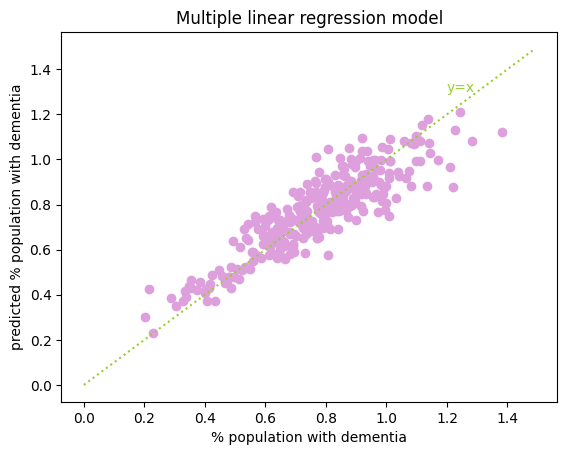

In [116]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(y, y_pred, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
#plt.text(0.2, 0.12, r'potential underdiagnosis', fontsize=10)
plt.show()

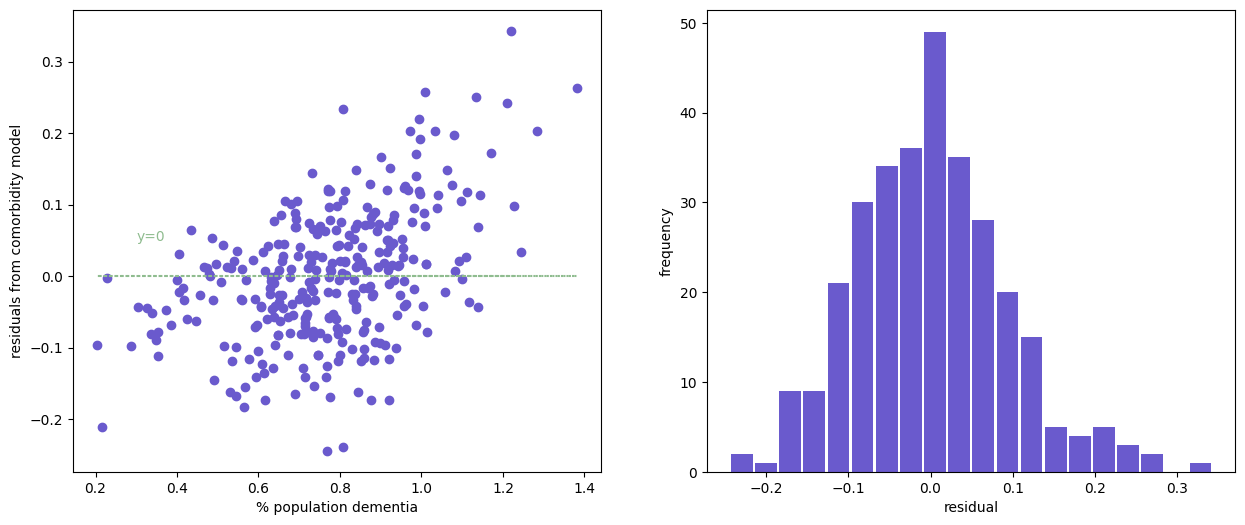

In [117]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

residuals = (y - y_pred).reshape(309)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y, residuals, color='slateblue')
plt.plot(y, np.zeros(len(y)), ':', color='darkseagreen')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, color='slateblue', rwidth=0.9, bins=20)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

And repeat without the GP covariate 

In [118]:
# Linear regression using sklearn 

x_noGP = df_dem_plus[covar_opt_noGP].values.reshape(-1,len(covar_opt_noGP))
y = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr_noGP = linear_model.LinearRegression()

# fit regression comorbidities
regr_noGP.fit(x_noGP, y)
y_pred_noGP = regr_noGP.predict(x_noGP)

print("Regression estimates \n--------------\n--------------")
print(f'Intercept:{regr_noGP.intercept_[0]}')
print("--------------\nCoefficients of independent variables \n--------------")
for i, var in enumerate(covar_opt_noGP):
    print(f'{var}:{regr_noGP.coef_[0][i]} \n')

Regression estimates 
--------------
--------------
Intercept:0.11672466720547925
--------------
Coefficients of independent variables 
--------------
over_65_pc:0.014731138015605591 

female_pc:-0.0007467545292659536 

ALevel_plus_pc:-0.0003392983880587491 

white_pc:-0.0004233160088976902 

HYP_afflicted_pc:0.02005156335838546 

DM_afflicted_pc:-0.02548760002158837 

STIA_afflicted_pc:0.13023891810059243 



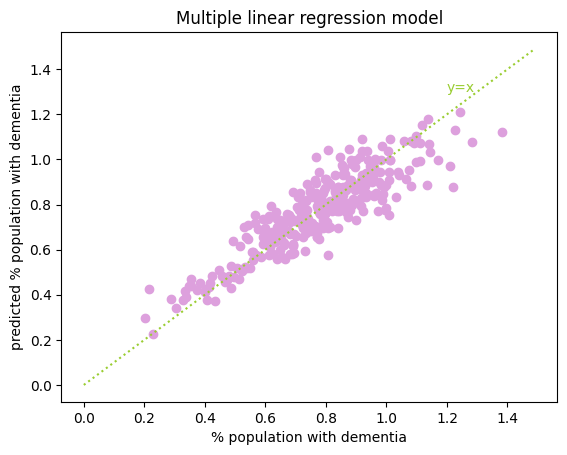

In [119]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(y, y_pred_noGP, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
#plt.text(0.2, 0.12, r'potential underdiagnosis', fontsize=10)
plt.show()

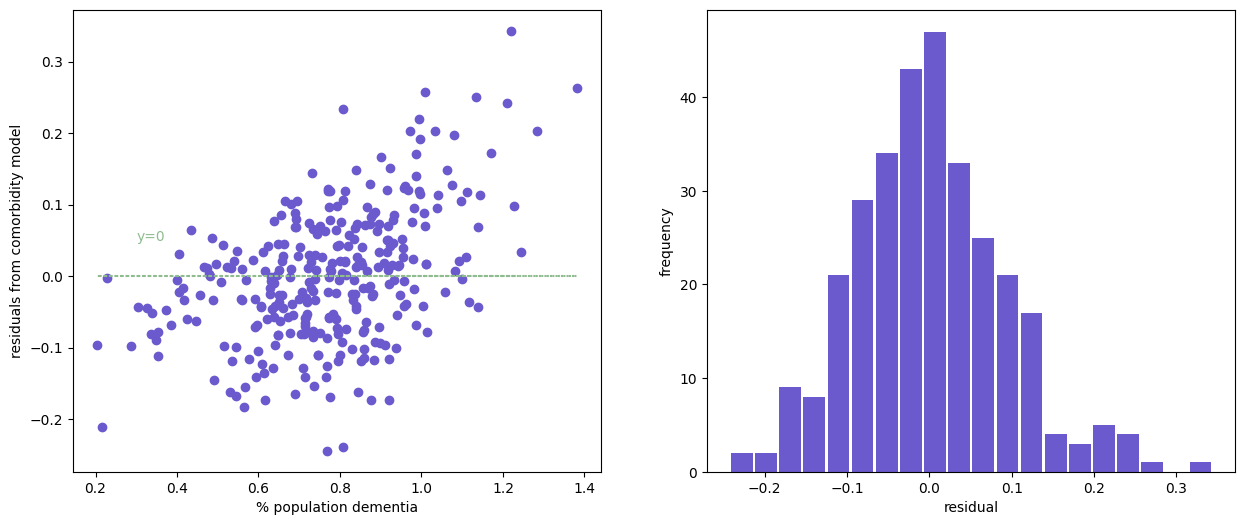

In [120]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

residuals_noGP = (y - y_pred_noGP).reshape(309)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y, residuals, color='slateblue')
plt.plot(y, np.zeros(len(y)), ':', color='darkseagreen')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(residuals_noGP, color='slateblue', rwidth=0.9, bins=20)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

### Save the results of the regression model to a .csv 

In [121]:
# add columns of results to the dataframe 
df_dem_plus['reg_model_residuals'] = residuals
df_dem_plus['reg_model_pred'] = y_pred

df_dem_plus['reg_model_noGP_residuals'] = residuals_noGP
df_dem_plus['reg_model_noGP_pred'] = y_pred_noGP

# save the dataframe 
df_dem_plus.to_csv(const.output_path+'/reg_model/reg_model_results.csv')

### And analyse the residuals 

In [28]:
# residuals 

# look at areas with gap between predicted diagnosis rate and observed diagnosis rate 
resid_gap_area = df_dem_plus[residuals<-0.15]['area_name']
print(resid_gap_area)
#[x for x in list(resid_gap_area)]

40                South Hams
60                 Worcester
75                  Redditch
79                  Wychavon
107                 Cornwall
134              Scarborough
242       North Lincolnshire
253                 Basildon
271                     Eden
274                   Thanet
283           City of London
286                 Torridge
288                 Plymouth
294    Nuneaton and Bedworth
Name: area_name, dtype: object


In [29]:
worst_5_resid = np.argsort(residuals)[-15:]
df_dem_plus.iloc[worst_5_resid, :][['area_name', 'DEM_afflicted_pc', 'over_65_pc', 'ALevel_plus_pc', 'female_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']]

,area_name,DEM_afflicted_pc,over_65_pc,ALevel_plus_pc,female_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc
129,Epping Forest,0.899773,24.677895,49.800170,64.915330,75.6,13.882619,5.564160,1.621331,0.176522
183,Waverley,0.985872,27.791540,63.260453,65.534887,86.8,14.041573,4.469473,1.785351,0.106896
149,Lewes,1.170738,31.025283,49.764974,60.497993,88.9,16.890490,5.697194,2.537976,0.161135
3,Lancaster,0.996946,23.914299,53.341341,58.934576,87.8,13.640026,5.506448,2.148768,0.497021
25,Worthing,1.079854,27.574793,50.175539,63.322383,85.0,16.385577,6.617740,2.314350,0.129606
99,Tendring,1.283029,35.816185,35.912813,62.635288,93.5,19.764338,7.942757,2.607929,0.139813
272,Gosport,1.032217,25.530861,43.336177,60.593137,92.5,16.899720,7.549057,2.248049,0.096413
138,Ashfield,0.971340,24.035047,38.988067,62.029490,91.8,15.116941,7.104318,2.114259,0.109193
10,Southend-on-Sea,0.993866,23.600073,44.333027,63.109901,81.6,15.104013,5.784186,1.922887,0.147230
225,Southampton,0.808419,16.705164,51.816027,59.824464,68.1,11.039538,5.131145,1.630277,0.165229


## We can compare these results to IMD data 

In [30]:
df_IMD = pd.read_excel(const.data_path+'/IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx', sheet_name='IMD')

df_IMD[df_IMD['Local Authority District name (2019)'].isin(resid_gap_area)]

,Local Authority District code (2019),Local Authority District name (2019),IMD - Average rank,IMD - Rank of average rank,IMD - Average score,IMD - Rank of average score,IMD - Proportion of LSOAs in most deprived 10% nationally,IMD - Rank of proportion of LSOAs in most deprived 10% nationally,IMD 2019 - Extent,IMD 2019 - Rank of extent,IMD 2019 - Local concentration,IMD 2019 - Rank of local concentration
12,E06000013,North Lincolnshire,17200.38,120,22.096,115,0.1089,81,0.2043,104,30774.98,87
25,E06000026,Plymouth,19859.59,72,26.619,64,0.1739,50,0.3060,56,31468.47,63
48,E06000052,Cornwall,19382.41,83,23.072,101,0.0521,121,0.1323,141,29411.09,123
69,E07000030,Eden,14688.07,169,16.328,186,0.0000,195,0.0046,280,22163.56,262
83,E07000044,South Hams,12057.07,219,13.724,229,0.0000,195,0.0012,289,20908.71,276
85,E07000046,Torridge,20086.96,67,23.269,99,0.0000,195,0.1025,160,27564.45,171
92,E07000066,Basildon,17744.60,111,23.243,100,0.1091,80,0.2623,76,30503.62,94
136,E07000114,Thanet,21985.10,34,31.314,30,0.2143,37,0.3642,42,32447.07,15
184,E07000168,Scarborough,19755.65,75,26.280,69,0.1268,70,0.2609,77,31915.58,41
224,E07000219,Nuneaton and Bedworth,18479.36,101,23.540,96,0.0617,110,0.2093,98,30644.86,92


In [31]:
df_dem_plus['residual'] = residuals

In [32]:
df_dem_plus_IMD = pd.merge(df_dem_plus, df_IMD[['IMD - Rank of average rank ', 'Local Authority District name (2019)']], left_on='area_name', right_on='Local Authority District name (2019)')

In [33]:
df_dem_plus_IMD.drop(columns='Local Authority District name (2019)', inplace=True)

In [34]:
df_dem_plus_IMD

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc,reg_model_residuals,reg_model_pred,Model residuals,residual,IMD - Rank of average rank
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,19.073111,6.164929,2.948652,215.158147,0.142036,0.097822,1.129095,0.097822,0.097822,241
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,10.372597,3.650571,1.287952,437.450820,0.278995,0.044718,0.603430,0.044718,0.044718,297
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,13.584680,4.848008,1.987987,123.466346,0.129934,0.151230,0.770931,0.151230,0.151230,273
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,13.640026,5.506448,2.148768,612.399689,0.497021,0.191349,0.805597,0.191349,0.191349,112
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,15.965501,6.298085,2.250735,77.360723,0.113788,-0.092747,0.898480,-0.092747,-0.092747,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,E07000098,Hertsmere,82921,670.292640,11021.724346,4685.682668,1328.437922,46875.0,56088.1445,51979.7732,...,13.291837,5.650779,1.602052,222.131324,0.267883,0.106923,0.701428,0.106923,0.106923,224
302,E08000024,Sunderland,228781,1815.593270,39805.733965,15607.611455,5391.466952,94211.0,141179.1277,133107.8801,...,17.399056,6.822075,2.356606,398.125138,0.174020,-0.072001,0.865596,-0.072001,-0.072001,33
303,E06000050,Cheshire West and Chester,281913,2115.072286,42946.758704,16327.686339,5778.511168,157848.0,182966.3133,174617.3565,...,15.234047,5.791747,2.049750,293.938550,0.104266,-0.079772,0.830029,-0.079772,-0.079772,183
304,E07000210,Mole Valley,72165,707.782207,10694.196102,3455.860767,1495.801962,42396.0,44954.5255,42642.7851,...,14.819090,4.788832,2.072753,117.926289,0.163412,0.095084,0.885699,0.095084,0.095084,294


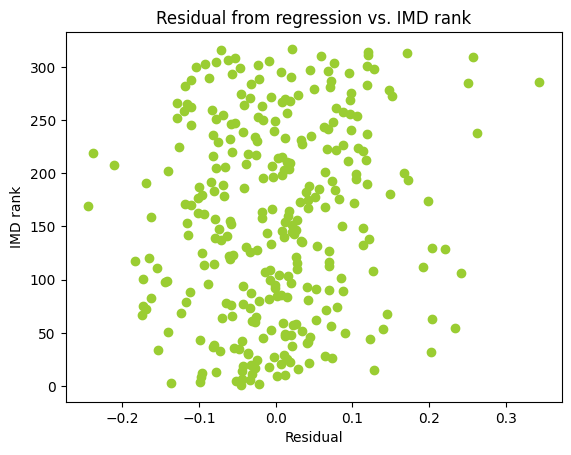

In [35]:
plt.scatter(df_dem_plus_IMD['residual'], df_dem_plus_IMD['IMD - Rank of average rank '], color='yellowgreen')
plt.xlabel('Residual')
plt.ylabel('IMD rank')
plt.title('Residual from regression vs. IMD rank')
plt.show()

### Ridge regression 

In [36]:
# Linear regression using sklearn and ridge regression

x = df_dem_plus[covar_opt].values.reshape(-1,len(covar_opt))
y = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.Ridge(alpha=1)

# fit regression comorbidities
regr.fit(x, y)
y_pred = regr.predict(x)

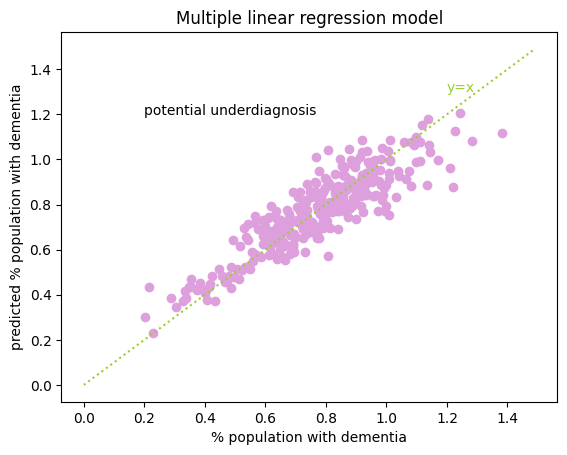

In [37]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(y, y_pred, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10)
plt.show()

In [38]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:0.11703539653974226
-------- 
 coefficients of independent variables 
 
over_65_pc:0.015435908998688307 

female_pc:-0.0010617668430306104 

ALevel_plus_pc:-0.0003304543949539135 

white_pc:-0.0002993248373520697 

HYP_afflicted_pc:0.020164840583129 

DM_afflicted_pc:-0.023206789957141937 

STIA_afflicted_pc:0.11501495474716382 

GP_LAD_pc:0.04025580739331951 



In [39]:
#np.dot(np.array(x), regr.coef_[0]) + regr.intercept_[0]

### Lasso regression 

In [40]:
# Linear regression using sklearn and lasso 

x = df_dem_plus[covar_opt].values.reshape(-1,len(covar_opt))
y = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.Lasso(alpha=0.001)

# fit regression comorbidities
regr.fit(x, y)
y_pred = regr.predict(x)

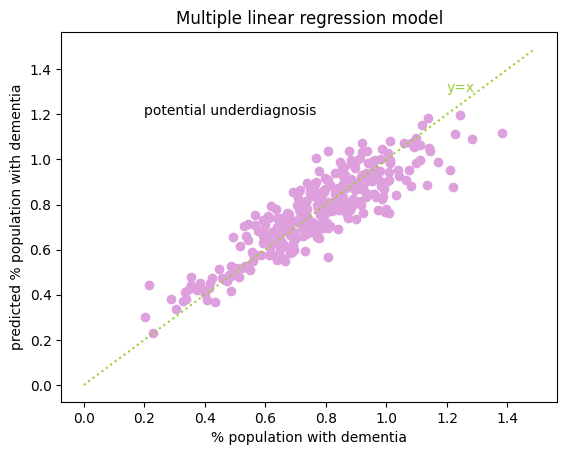

In [41]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(y, y_pred, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10)
plt.show()

In [42]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[i]} \n')

intercept:0.1035994257018823
-------- 
 coefficients of independent variables 
 
over_65_pc:0.0167110984329495 

female_pc:-0.0017726595204652544 

ALevel_plus_pc:0.00016572678039928113 

white_pc:8.331348404865453e-05 

HYP_afflicted_pc:0.018017842454425607 

DM_afflicted_pc:-0.013673389133534226 

STIA_afflicted_pc:0.09053607798856679 

GP_LAD_pc:0.0 

